# Deep Learning Minor Homework 3.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import SGD, Adam

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error

import random
import os.path
import datetime

import urllib
from bs4 import BeautifulSoup

Using TensorFlow backend.


## Generate the dates used

Our dataset starts at 2009 August, so we generate months from that date until present:

In [2]:
currentDate = datetime.datetime.now()
years = range(2009, currentDate.year+1)
months = range(1, 13)
dates = [[y,m] for y in years for m in months if not 
         ((y == currentDate.year and m > currentDate.month)
          or
          (y == 2009 and m < 8)
         )]

The days in the future to be predicted:

In [3]:
futureDays = [1, 7, 28]

# Downloading data

## Scraping a website for weather data

I used data from three cities:
- Budapest, where the weather is to be predicted,
- Szeged and Vienna which are located in the direction of dominant winds: their weather might be a good indication of future Budapest weather.

In [4]:
cities = [10602, # Budapest XI: district
          1023, # Szeged
          5412 # Vienna
         ]
nCity = len(cities)

Download the data form `metnet.hu`

In [5]:
def downloadMonths(dates, cities):
    url = 'https://www.metnet.hu/napi-adatok'
    dataset = []
    for d in dates:
        monthDataByCities = []
        for c in cities:
            params = {"sub" : "4",
                      "pid" : c,
                      "date" : str(d[0]) + "-" + str(d[1])}
            # Query the site:
            queryString = urllib.parse.urlencode(params)
            req = urllib.request.Request(url + '?' + queryString)
            # Parse the result:
            soup = BeautifulSoup(urllib.request.urlopen(req).read(), 'html.parser')
            #weatherData = extractWeatherDataFromSoup(soup)
            monthTable = [
                [
                    [td.get_text(" ", strip=True) for td in tr.find_all('td')]
                    for tr in table.find_all('tr')
                ] 
            for table in soup.find_all('table')
            ][1]
            monthWeatherData = [
                [
                    d[0], # Year
                    d[1], # Month
                    int(m[0][:-1]), # Day
                    # Weather data:
                    # Convert min, max temp (Celsius) and rainfall (mm) to float
                    # There are a really small amount of days when the rain is not
                    # logged, those can be assumed to be zero
                    *[float(mi[:-3].replace(',', '.')) if mi != '' else 0 for mi in m[1:4]]
                ]   
                for m in monthTable[1:] if m[0][0:7] != 'Leírás:'
            ]
            monthDataByCities.append(monthWeatherData)
        # Merge the data of separate cities by date
        # and add them to the dataset
        monthDataByCities = np.array(monthDataByCities)
        for i in range(monthDataByCities.shape[1]):
            row = [*monthDataByCities[0,i,:2],
                   monthDataByCities[0,i,2],
                   *monthDataByCities[:,i,3:].flatten()]
            dataset.append(row)
        print(d)
    return dataset

## Generating the training dataset

This section only needs to be ran for generating the training dataset.

In [6]:
dataset = []
dataset = downloadMonths(dates, cities)

[2009, 8]
[2009, 9]
[2009, 10]
[2009, 11]
[2009, 12]
[2010, 1]
[2010, 2]
[2010, 3]
[2010, 4]
[2010, 5]
[2010, 6]
[2010, 7]
[2010, 8]
[2010, 9]
[2010, 10]
[2010, 11]
[2010, 12]
[2011, 1]
[2011, 2]
[2011, 3]
[2011, 4]
[2011, 5]
[2011, 6]
[2011, 7]
[2011, 8]
[2011, 9]
[2011, 10]
[2011, 11]
[2011, 12]
[2012, 1]
[2012, 2]
[2012, 3]
[2012, 4]
[2012, 5]
[2012, 6]
[2012, 7]
[2012, 8]
[2012, 9]
[2012, 10]
[2012, 11]
[2012, 12]
[2013, 1]
[2013, 2]
[2013, 3]
[2013, 4]
[2013, 5]
[2013, 6]
[2013, 7]
[2013, 8]
[2013, 9]
[2013, 10]
[2013, 11]
[2013, 12]
[2014, 1]
[2014, 2]
[2014, 3]
[2014, 4]
[2014, 5]
[2014, 6]
[2014, 7]
[2014, 8]
[2014, 9]
[2014, 10]
[2014, 11]
[2014, 12]
[2015, 1]
[2015, 2]
[2015, 3]
[2015, 4]
[2015, 5]
[2015, 6]
[2015, 7]
[2015, 8]
[2015, 9]
[2015, 10]
[2015, 11]
[2015, 12]
[2016, 1]
[2016, 2]
[2016, 3]
[2016, 4]
[2016, 5]
[2016, 6]
[2016, 7]
[2016, 8]
[2016, 9]
[2016, 10]
[2016, 11]
[2016, 12]
[2017, 1]
[2017, 2]
[2017, 3]
[2017, 4]
[2017, 5]
[2017, 6]
[2017, 7]
[2017, 8]
[2017,

In [7]:
dataset[-1]

[2019.0, 10.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

The latest month's data has empty rows after (and sometimes including) the present day, drop those, and make a numpy array:

In [8]:
dataset = np.array(
    [d for d in dataset if not (d[0]==currentDate.year and d[1]==currentDate.month and d[2]>=currentDate.day)])

The resulting dataset has 12 columns:

In [9]:
header = ['Year', 'Month', 'Day', 
          'Min temperature C [Budapest XI]', 'Max temperature C [Budapest XI]', 'Rain mm [Budapest XI]',
          'Min temperature C [Szeged]', 'Max temperature C [Szeged]', 'Rain mm [Szeged]',
          'Min temperature C [Sopron]', 'Max temperature C [Sopron]', 'Rain mm [Sopron]',
         ]
dataset[-1]

array([2.019e+03, 1.000e+01, 2.800e+01, 9.900e+00, 1.970e+01, 0.000e+00,
       5.200e+00, 2.080e+01, 0.000e+00, 9.400e+00, 1.930e+01, 5.000e-01])

Visualize the min and max temperatures over time in Budapest:

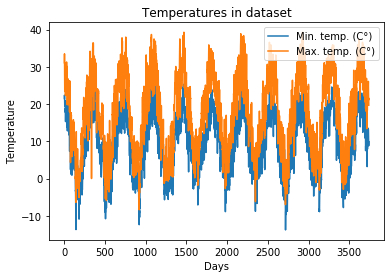

In [10]:
plt.plot(dataset[:,3])
plt.plot(dataset[:,4])
plt.title('Temperatures in dataset')
plt.ylabel('Temperature')
plt.xlabel('Days')
plt.legend(['Min. temp. (C°)', 'Max. temp. (C°)'], loc='upper right')
plt.show()

It seems that the date might be a good feature; we can make a rough estimate based on it, so it will certainly be included in the model.

Save the base dataset as CSV:

In [11]:
df = pd.DataFrame(dataset, columns=header)
df.to_csv('weatherData.csv', index=False)

# Generating training sets

This only uses the previously generated CSV file:

In [12]:
def createXfromRaw(dataset, futureDays, nCity, n):
    farthestDay = max(futureDays)
    trainingData = []
    for i in range(n, len(dataset)-farthestDay):
        # Join the inputs and outputs into a single 1D array:
        x = np.ndarray(2 + n*3*nCity)
        # The inputs as defined above:
        x[0:2] = dataset[i][1:3].flatten()
        x[2:2 + n*3*nCity] = dataset[(i-n+1):(i+1)][:,3:(3+nCity*3)].flatten()
        trainingData.append(x)
    return np.array(trainingData)

def createYfromRaw(dataset, futureDays, nCity, n):
    farthestDay = max(futureDays)
    days = len(futureDays)
    trainingData = []
    for i in range(n, len(dataset)-farthestDay):
        # Join the inputs and outputs into a single 1D array:
        y = np.ndarray(days)
        # The output is the mean temperature in Budapest after the specified days
        for d in range(1,len(futureDays)+1):
            y[-d] = np.mean(dataset[i+futureDays[-d]][3:5])
        trainingData.append(y)
    return np.array(trainingData)

In [13]:
def createTrainingData(nCity, n, futureDays=[1, 7, 28]):
     # Data
    df = pd.read_csv("weatherData.csv")
    dataset = df.values
    
    indices = list(range(dataset.shape[0]))
    #random.shuffle(indices)
    
    test_split = 0.1
    valid_split = 0.1

    valid_index = int(dataset.shape[0]*(1-valid_split-test_split))
    test_index = int(dataset.shape[0]*(1-test_split))

    i_train = indices[:valid_index]
    i_valid = indices[valid_index:test_index]
    i_test = indices[test_index:]

    # Testing data
    X_test = createXfromRaw(dataset[i_test], futureDays, nCity, n)
    Y_test = createYfromRaw(dataset[i_test], futureDays, nCity, n)

    # Validation data
    X_valid = createXfromRaw(dataset[i_valid], futureDays, nCity, n)
    Y_valid = createYfromRaw(dataset[i_valid], futureDays, nCity, n)
    
    # Training data
    X_train = createXfromRaw(dataset[i_train], futureDays, nCity, n)
    Y_train = createYfromRaw(dataset[i_train], futureDays, nCity, n)
    
    # Scaling
    scalerX = StandardScaler().fit(X_train)
    X_train = scalerX.transform(X_train)
    X_valid = scalerX.transform(X_valid)
    X_test = scalerX.transform(X_test)
    
    scalerY = MinMaxScaler().fit(Y_train)
    Y_train = scalerY.transform(Y_train)
    Y_valid = scalerY.transform(Y_valid)
    Y_test = scalerY.transform(Y_test)
    
    return X_train, X_valid, X_test, Y_train, Y_valid, Y_test, scalerX, scalerY

# Grid search

For hyperparameter-optimalization, I ran a grid search on the following hyperparameter-space:

In [14]:
possible_parameters = {
    'n' : [3, 7, 14, 21, 30],
    'dropout_prob' : [0, 0.1, 0.2, 0.25, 0.4],
    'es_patience' : [20, 40, 60],
    'rop_patience' : [1, 5, 10, 20],
    'rop_factor' : [0.1, 0.2, 0.5],
    'activation' : ['elu', 'relu'],
    'layer_sizes' : [0.25, 0.5, 1, 1.5, 2, 4],
    'adam_lr' : [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05],
    'batch_size' : [16, 32, 64, 128]
}

For this we need to parametrically generate DNN-s:

In [15]:
def weatherModel(hp, verbosity=0, days=3):
    nCity = 3
    
    n = hp['n']
    
    X_train, X_valid, X_test, Y_train, Y_valid, Y_test, scalerX, scalerY = createTrainingData(nCity, n)
    
    # print(X_train[0])
    # print(Y_train[0])
    
    early_stopping = EarlyStopping(patience = hp['es_patience'], verbose = 1)
    checkpointer =  ModelCheckpoint(filepath = 'weights.hdf5', save_best_only = True)
    reduceOnPlateu = ReduceLROnPlateau(monitor='val_loss', 
                                                factor=hp['rop_factor'], patience=hp['rop_patience'], 
                                                verbose=0, mode='auto', 
                                                min_delta=0.0001, cooldown=0, min_lr=0)
    
    input_dim=X_train.shape[1]
    
    ## Network
    model = Sequential()

    # Input layer
    model.add(Dense(int(input_dim*hp['layer_sizes'][0]),
                    input_dim=input_dim))
    model.add(Activation(hp['activation']))
    model.add(Dropout(hp['dropout_prob']))

    # Hidden layers
    for i in range(1, len(hp['layer_sizes'])):
        model.add(Dense(int(input_dim*hp['layer_sizes'][i])))
        model.add(Activation(hp['activation']))
        model.add(Dropout(hp['dropout_prob']))

    # Output layer
    model.add(Dense(days, activation='linear'))
    
    
    adam = Adam(lr=hp['adam_lr'])
    model.compile(loss='mse', optimizer = adam)
    
    random.seed()
    
    history = model.fit(X_train, Y_train, epochs = 1000,
                    batch_size = hp['batch_size'],
                    verbose = verbosity,
                    validation_data = (X_valid, Y_valid),
                    callbacks = [checkpointer, early_stopping, reduceOnPlateu])
    
    # Error
    
    preds = model.predict(X_test)
    
    test_err = mean_squared_error(Y_test, preds)
    mse_test = test_err
    eC_test = np.sqrt(test_err)/scalerY.scale_[0]
        
    return (hp, history, (mse_test, eC_test)), model

In [16]:
def tryRandomWeatherModel(possible_parameters, futureDays = [1, 7, 28],verbosity=0):
        
    # Hyperparameters
    hp = {}
    
    days = len(futureDays)
    
    layer_num = random.choice([3, 4, 5, 6, 7, 8])
    for p in possible_parameters:
        if p is 'layer_sizes':
            hp[p] = []
            for i in range(layer_num):
                hp[p].append(random.choice(possible_parameters[p]))
        else:
            hp[p] = random.choice(possible_parameters[p])
    
    print()
    print("---------")
    print(hp)
    print("Training...")
    
    (hp, history, (mse_test, eC_test)), model = weatherModel(hp, days=days, verbosity=verbosity)
    
    print("MSE of test data:", mse_test)
    print("in Celsius:", eC_test)
    
    return hp, history, (mse_test, eC_test)


Running the grid search and saving params and results to a file (this is an infinite loop that I ran for about a thousand grid points for a day):

In [ ]:
# Infinite loop, only run when grid search is needed!

filename = "gridSearch.csv"

if os.path.isfile(filename):
    file = open(filename, 'a')
else:
    file = open(filename, 'w')
    header = [*possible_parameters.keys(), "MSE", "Celsius error"]
    file.write(';'.join(header) + "\n")

while True:
    try:
        params, history, error = tryRandomWeatherModel(possible_parameters,
                                                      verbosity = 0, futureDay = futureDays)
        row = [*params.values(), *error]
        row = [str(r) for r in row]
        file.write(';'.join(row) + "\n")
        
    except KeyboardInterrupt:
        print("Keyboard interrupt!")
        file.close()
        break
    except Exception as e:
        print(e)
        file.close()

# The final model

Almost 1000 different grid points were tried. The best hyperparameters found were these:

In [17]:
hp = {'n': 7,
 'dropout_prob': 0.1,
 'es_patience': 40,
 'rop_patience': 5,
 'rop_factor': 0.1,
 'activation': 'elu',
 'layer_sizes': [2, 0.5, 2, 0.25, 2],
 'adam_lr': 0.005,
 'batch_size': 32}

Retrain a model using these to see the details:

In [18]:
X_train, X_valid, X_test, Y_train, Y_valid, Y_test, scalerX, scalerY = createTrainingData(3, hp['n'])

In [19]:
etc, model = weatherModel(hp, verbosity = 1)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Train on 2957 samples, validate on 339 samples
Epoch 1/1000
2957/2957 [==============================] - 5s 2ms/step - loss: 0.0444 - val_loss: 0.0108
Epoch 2/1000
2957/2957 [==============================] - 1s 454us/step - loss: 0.0148 - val_loss: 0.0098
Epoch 3/1000
2957/2957 [==============================] - 1s 377us/step - loss: 0.0130 - val_loss: 0.0104
Epoch 4/1000
2957/2957 [==============================] - 1s 352us/step - loss: 0.0125 - val_loss: 0.0098
Epoch 5/1000
2957/2957 [==============================] - 1s 435us/step - loss: 0.0116 - val_loss: 0.0092
Epoch 6/1000
2957/2957 [==============================] - 1s 340us/step - loss: 0.0112 - val_loss: 0.0097
Epoch 7/1000
2957/2957 [==============================] - 1s 347us/step - loss: 0.0108 - val_loss: 0.0092
Epoch 8/1000
2957/2957 [==============================] - 1s 341us/step - loss: 0.0109 - val

In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 130)               8580      
_________________________________________________________________
activation_1 (Activation)    (None, 130)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 130)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4192      
_________________________________________________________________
activation_2 (Activation)    (None, 32)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 130)               4290      
__________

Plot the training history:

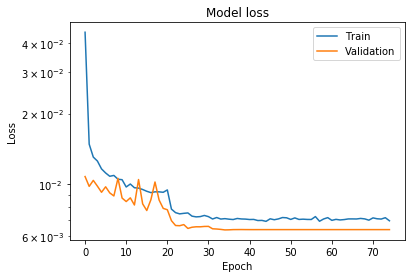

In [21]:
history = etc[1]
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
#plt.xscale('log')
plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

## Accuracy

In [22]:
from sklearn.metrics import mean_squared_error
preds = model.predict(X_test)
test_err = mean_squared_error(Y_test, preds)
print("MSE on test data (scaled):", test_err)
print("Mean error on test data (Celsius):", np.sqrt(test_err)/scalerY.scale_[0])

MSE on test data (scaled): 0.005673421806295272
Mean error on test data (Celsius): 3.182359582621039


In [23]:
for i in range(len(futureDays)):
    mse = mean_squared_error(Y_test[:,i], preds[:,i])
    celsius = np.sqrt(mse)/scalerY.scale_[0]
    print("MSE on test data for {} days in the future (scaled):".format(futureDays[i]), mse)
    print("Mean error on test data for {} days in the future (Celsius):".format(futureDays[i]), celsius)
    print()

MSE on test data for 1 days in the future (scaled): 0.0022202645122983565
Mean error on test data for 1 days in the future (Celsius): 1.9908066005980052

MSE on test data for 7 days in the future (scaled): 0.006806629368785715
Mean error on test data for 7 days in the future (Celsius): 3.4857221400476046

MSE on test data for 28 days in the future (scaled): 0.007993371537801743
Mean error on test data for 28 days in the future (Celsius): 3.7773890163308868



In [24]:
predsC = scalerY.inverse_transform(preds)
Y_testC = scalerY.inverse_transform(Y_test)
diff = (predsC-Y_testC).T

The accuracy of the predictions spread out as we look at farther days:

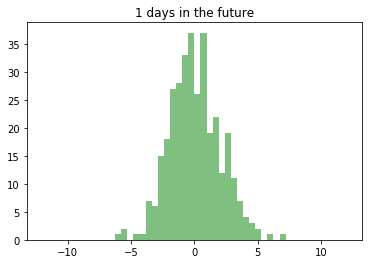

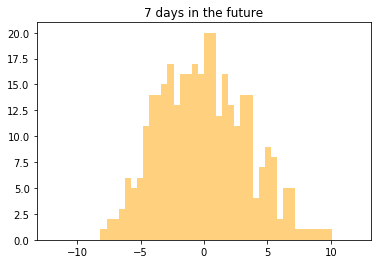

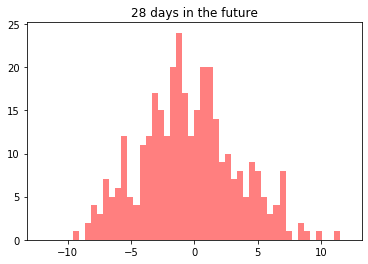

In [25]:
colors = ['green', 'orange', 'red']
for i in range(len(diff)):
    plt.hist(diff[i], 50, range = (-12, 12), facecolor=colors[i], alpha=0.5)
    plt.title(str(futureDays[i]) + ' days in the future')
    plt.show()

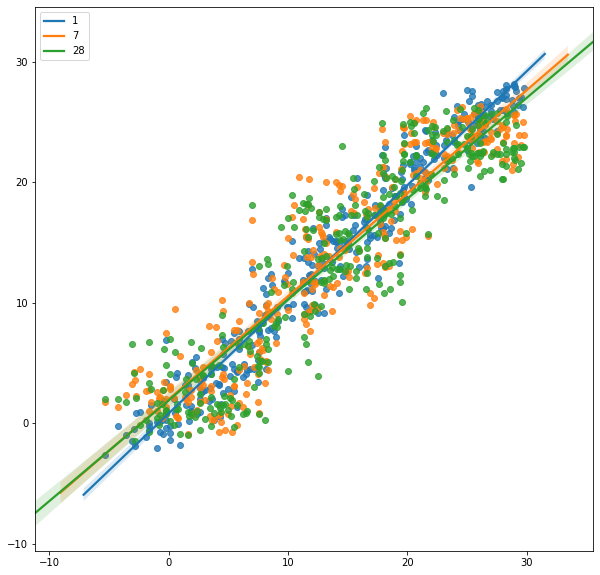

In [26]:
import seaborn as sns
plt.figure(figsize=(10,10))
for i in range(len(futureDays)):
    sns.regplot(x=Y_testC[:,i], y=predsC[:,i].reshape(-1), label=str(futureDays[i]))
plt.legend(labels=futureDays)

# Final prediction

Get the latest data for the current month:

In [27]:
todayDataset=downloadMonths([[2019,10]], cities)

[2019, 10]


Delete the empty rows of future days:

In [28]:
todayDataset = np.array(
    [d for d in todayDataset if not (d[0]==currentDate.year and d[1]==currentDate.month and d[2]>currentDate.day)])

Check today's data:

In [29]:
todayDataset[-1]

array([2019. ,   10. ,   29. ,    9.8,    0. ,    0. ,    0. ,   14.4,
          0. ,    0. ,    0. ,    0. ])

Sadly today's data has not fully been uploaded to `metnet.hu` as of 10.29. 21:30. Because of this, today's data is filled in with data from `wunderground.com` at stations IBUDAP20 (Budapest XI.), ISZEGE1 (Szeged) and IINNER3 (Vienna Innere Stadt). Of course this approach is a bit flawed, since these data sources are a bit different from those previously used, but because of the time constraint I had no real other choicem and the they should be similar since it is the same weather measured after all.

In [30]:
todayDataset[-1] = np.array([2019., 10., 29., 7.8, 10.6, 3.1, 7.2, 12.4, 3.8, 7.6, 11.8, 0.])

In [31]:
todayDataset[-1]

array([2019. ,   10. ,   29. ,    7.8,   10.6,    3.1,    7.2,   12.4,
          3.8,    7.6,   11.8,    0. ])

In [32]:
todayX = createXfromRaw(todayDataset[-hp['n']-1:], [0], nCity, hp['n'])

In [33]:
todayX

array([[10. , 29. , 13. , 26.1,  0. ,  8.2, 26.8,  0. , 13.3, 21.4,  0. ,
        12.9, 24.2,  0. ,  7. , 25.5,  0. , 12.8, 25.3,  0. , 10.6, 24.6,
         0. ,  6.2, 24. ,  0. , 13.1, 21.6,  0. ,  9.1, 21.1,  0. ,  6.5,
        22.1,  0. , 10.8, 18.7,  0. ,  8.8, 21.6,  0. ,  3.4, 21.6,  0. ,
         9.5, 24.1,  1.1,  9.9, 19.7,  0. ,  5.2, 20.8,  0. ,  9.4, 19.3,
         0.5,  7.8, 10.6,  3.1,  7.2, 12.4,  3.8,  7.6, 11.8,  0. ]])

In [34]:
scalerY.inverse_transform(model.predict(scalerX.transform(todayX)))

array([[8.177751, 9.131339, 6.839386]], dtype=float32)

So the mean temperature predictions for the desired days are:
* 30th October: 8.2 °C
* 5th November: 9.2 °C
* 26th November: 6.8 °C